We're artificially creating a df with the mean count of every intensity for every protein.

Steps:  
We know how many images were used for each protein.  
We're counting how many pixels there are for each intensity in ALL images of the protein.  
We divide the pixel count per intensity by the number of images.

BUT  
Since we might have smaller pixel count per intensity than the number of images in a condition (and even if it's not smaller, it might be a small enough number and we will lose data in the process), we first bin the pixel values to bins of size 20. 

In [1]:
#import packages
import pandas as pd
import struct
import xml.etree.ElementTree as ET
from copy import copy
from pathlib import Path
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from matplotlib import rcParams

In [2]:
## comment if made into .py file
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_colwidth",50)

In [3]:
# select input and output paths
frap_database_csv_path = '.../database/FRAP_database_2_new_filtered.csv'
frap_database_csv_output_path = '.../FRAP_database_2_new_filtered_2.csv'
plots = '.../intensity_files'


In [4]:
df_frap = pd.read_csv(frap_database_csv_path)

In [5]:
df_frap.head(5)

,Unnamed: 0,filename,experiment,protein,condition,tau,t_half,t_half2,mobile_fraction,bleach_values,time_steps,sse,rsquare,date,strain,immobile_fraction,SeriesNum,BitSize,LineAverage,OutDimension,ScanDirectionX,ScanDirectionXName,PixelDwellTime,Zoom,ScanSpeed,Pinhole,PinholeAiry,LaserLine,IntensityDev,Gain,OutputPowerPercentage,PhaseX,FRAP_num_pure,FRAP_num_suff,unique_pixel_vals,unique_vals_count
0,0,200530_SPL8_hs1hr35_rc8hr20_lif_-_FRAP_006_pya...,200530_spl8,DPY-27,NaN,5.805892,4.18,3.30,0.374834,"[1.060889, 1.008881, 1.053333, 1.02661, 1.0139...","[0.22, 0.44, 0.66, 0.88, 1.1, 1.32, 1.54, 1.76...",0.249890,0.49793,200530,spl8,0.625166,11.0,12.0,1.0,256.0,2.0,Bidirectional,0.000002,7.001,600.0,0.000103,1.0,482.0,15.00067,169.915,0.71,29.752,NaN,NaN,"[127, 128, 129, 130, 131, 132, 133, 134, 135, ...","[1, 1, 1, 4, 1, 8, 2, 2, 2, 3, 6, 5, 7, 8, 6, ..."
1,1,200530_SPL8_hs1hr35_rc8hr20_lif_-_FRAP_007_pya...,200530_spl8,DPY-27,NaN,8.318542,5.94,3.96,0.264699,"[1.04635, 1.104421, 0.967013, 1.027364, 1.0217...","[0.22, 0.44, 0.66, 0.88, 1.1, 1.32, 1.54, 1.76...",0.172830,0.47933,200530,spl8,0.735301,13.0,12.0,1.0,256.0,2.0,Bidirectional,0.000002,7.001,600.0,0.000103,1.0,482.0,15.00067,169.915,0.71,29.752,NaN,NaN,"[101, 104, 109, 111, 117, 118, 119, 121, 123, ...","[1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 3, 1, 2, 2, 2, ..."
2,2,200530_SPL8_hs1hr35_rc8hr20_lif_-_FRAP_009_pya...,200530_spl8,DPY-27,NaN,1.604541,1.32,0.88,0.203197,"[1.054365, 1.025518, 1.035296, 1.023328, 1.027...","[0.22, 0.44, 0.66, 0.88, 1.1, 1.32, 1.54, 1.76...",0.175220,0.19545,200530,spl8,0.796803,17.0,12.0,1.0,256.0,2.0,Bidirectional,0.000002,7.013,600.0,0.000103,1.0,482.0,15.00067,169.915,0.71,29.752,NaN,NaN,"[244, 250, 251, 252, 253, 255, 256, 257, 258, ...","[2, 4, 2, 2, 2, 2, 1, 1, 2, 6, 4, 3, 9, 2, 6, ..."
3,3,200530_SPL8_hs1hr35_rc8hr20_lif_-_FRAP_029_pya...,200530_spl8,DPY-27,NaN,2.419760,1.98,1.10,0.166205,"[1.037188, 1.056412, 1.042269, 0.994047, 1.031...","[0.22, 0.44, 0.66, 0.88, 1.1, 1.32, 1.54, 1.76...",0.121620,0.10477,200530,spl8,0.833795,57.0,12.0,1.0,256.0,2.0,Bidirectional,0.000002,7.013,600.0,0.000103,1.0,482.0,15.00067,169.915,0.71,29.752,NaN,NaN,"[194, 199, 200, 203, 204, 205, 206, 207, 208, ...","[1, 1, 1, 2, 4, 1, 1, 2, 5, 7, 4, 6, 7, 11, 10..."
4,4,200530_SPL8_hs1hr35_rc8hr20_lif_-_FRAP_030_pya...,200530_spl8,DPY-27,NaN,8.138622,5.94,4.18,0.133133,"[1.045889, 1.021138, 0.995914, 1.00209, 1.0034...","[0.22, 0.44, 0.66, 0.88, 1.1, 1.32, 1.54, 1.76...",0.074685,0.41250,200530,spl8,0.866867,59.0,12.0,1.0,256.0,2.0,Bidirectional,0.000002,7.013,600.0,0.000103,1.0,482.0,15.00067,169.915,0.71,29.752,NaN,NaN,"[235, 237, 238, 239, 242, 244, 246, 248, 250, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, ..."


#### Create col pix_vals in df_frap

In [6]:
df_frap.unique_pixel_vals = df_frap.unique_pixel_vals.apply(lambda x: np.array(x[1:-1].split(',')).astype(int))
df_frap.unique_vals_count = df_frap.unique_vals_count.apply(lambda x: np.array(x[1:-1].split(',')).astype(int))

In [7]:
for ii in df_frap.index:
    df_frap.at[ii,'pixel_vals'] = str(list(chain(*[[v]*df_frap.at[ii,"unique_vals_count"][i] 
                              for i,v in enumerate(df_frap.at[ii,"unique_pixel_vals"])])))

In [8]:
df_frap.pixel_vals = df_frap.pixel_vals.apply(lambda x: np.array(x[1:-1].split(',')).astype(int))


#### For each protein get its images count

In [9]:
unique_proteins_and_counts = df_frap.protein.value_counts()

In [10]:
unique_proteins_and_counts

DPY-27 (DPY-21 jmjc)     101
DPY-27 (DPY-21 KO)        63
DPY-27 EQ short           44
DPY-27 set-4 KO           42
DPY-27 sir-2.1 KO         41
DPY-27 EQ                 36
DPY-27                    26
DPY-27 short recovery     21
DPY-27-halo                2
Name: protein, dtype: int64

In [11]:
unique_proteins_and_counts_asstr = [f'{idx} n={val}' for idx,val in unique_proteins_and_counts.items()]
unique_proteins_and_counts_asstr

['DPY-27 (DPY-21 jmjc) n=101',
 'DPY-27 (DPY-21 KO) n=63',
 'DPY-27 EQ short n=44',
 'DPY-27 set-4 KO n=42',
 'DPY-27 sir-2.1 KO n=41',
 'DPY-27 EQ n=36',
 'DPY-27 n=26',
 'DPY-27 short recovery n=21',
 'DPY-27-halo n=2']

#### Create a df with ALL pixel values (in all images) per protein 

In [12]:
df_protein_pixvalcount = pd.DataFrame({})

for i,u_p in enumerate(unique_proteins_and_counts_asstr):
    df_protein_pixvalcount[u_p] = pd.Series(np.hstack(df_frap[df_frap['protein']==u_p.split(" n=")[0]]['pixel_vals'].values))


In [13]:
df_protein_pixvalcount.head(5)

,DPY-27 (DPY-21 jmjc) n=101,DPY-27 (DPY-21 KO) n=63,DPY-27 EQ short n=44,DPY-27 set-4 KO n=42,DPY-27 sir-2.1 KO n=41,DPY-27 EQ n=36,DPY-27 n=26,DPY-27 short recovery n=21,DPY-27-halo n=2
0,71,186.0,240.0,181.0,65.0,241.0,127.0,237.0,91.0
1,71,189.0,242.0,181.0,66.0,241.0,128.0,237.0,91.0
2,72,192.0,242.0,182.0,66.0,243.0,129.0,239.0,92.0
3,72,193.0,242.0,182.0,68.0,245.0,130.0,241.0,94.0
4,72,193.0,242.0,182.0,68.0,247.0,130.0,242.0,95.0


#### Bin the pixel values
Why? because we want to divide the amount of all pixel values per protein by the amount of images
and if we go by a single pixel value we might not have enough count to divide it by the number of images of the protein.  
bin_size = 20 

In [14]:
## Get max pixel value for each protein (in all its images)
max_pix_vals = df_protein_pixvalcount.max()

In [15]:
## Create df of binned values:
df_protein_pixcount_binned = pd.DataFrame({})

val_count_per_series = []

for c in df_protein_pixvalcount.columns:
    df_protein_pixcount_binned[c] = pd.cut(df_protein_pixvalcount[c], 
                               range(0,int(max_pix_vals[c]),20), labels=range(10,int(max_pix_vals[c])-10,20))
    
    ## Get count after dividing by number of images per condition
    ## Its a list of series:
    ## Each list item (a series) is a protein.
    ## In each series we have the pixel value as an index and the final count it should have as value
    val_count_per_series.append(df_protein_pixcount_binned[c].value_counts().divide(int(c.split(" n=")[1])))

In [16]:
df_protein_pixcount_binned.head(10)

,DPY-27 (DPY-21 jmjc) n=101,DPY-27 (DPY-21 KO) n=63,DPY-27 EQ short n=44,DPY-27 set-4 KO n=42,DPY-27 sir-2.1 KO n=41,DPY-27 EQ n=36,DPY-27 n=26,DPY-27 short recovery n=21,DPY-27-halo n=2
0,70,190,230,190,70,250,130,230,90
1,70,190,250,190,70,250,130,230,90
2,70,190,250,190,70,250,130,230,90
3,70,190,250,190,70,250,130,250,90
4,70,190,250,190,70,250,130,250,90
5,70,190,250,190,70,250,130,250,90
6,70,190,250,190,70,250,130,250,90
7,70,190,250,190,70,250,130,250,90
8,70,190,250,190,70,250,130,250,110
9,70,190,250,190,70,250,130,250,110


In [17]:
## Make new dataframe with the mean count of pixel values:
df_mean_count_pixval = pd.DataFrame({})

for i,c in enumerate(df_protein_pixcount_binned.columns):
    series = val_count_per_series[i].astype(int).copy()
    series = series[series>0]
    #print(list(chain(*[[idx]*count for idx,count in series.items()])))
    df_mean_count_pixval[c] = pd.Series(list(chain(*[[idx]*count for idx,count in series.items()])))

In [18]:
df_mean_count_pixval.head(10)

,DPY-27 (DPY-21 jmjc) n=101,DPY-27 (DPY-21 KO) n=63,DPY-27 EQ short n=44,DPY-27 set-4 KO n=42,DPY-27 sir-2.1 KO n=41,DPY-27 EQ n=36,DPY-27 n=26,DPY-27 short recovery n=21,DPY-27-halo n=2
0,230,210.0,550,250.0,270.0,230,290,670,530.0
1,230,210.0,550,250.0,270.0,230,290,670,530.0
2,230,210.0,550,250.0,270.0,230,290,670,530.0
3,230,210.0,550,250.0,270.0,230,290,670,530.0
4,230,210.0,550,250.0,270.0,230,290,670,530.0
5,230,210.0,550,250.0,270.0,230,290,670,530.0
6,230,210.0,550,250.0,270.0,230,290,670,530.0
7,230,210.0,550,250.0,270.0,230,290,670,530.0
8,230,210.0,550,250.0,270.0,230,290,670,530.0
9,230,210.0,550,250.0,270.0,230,290,670,530.0


In [19]:
#Select colors for plotting
color_dict = {'DPY-27 n=26': "#8AB17D", 
              'DPY-27 (DPY-21 KO) n=63': "#52079C", 
              'DPY-27 (DPY-21 jmjc) n=101': "hotpink", 
              'DPY-27 EQ n=36': "#AF125A",
              'DPY-27 EQ short n=44': "#FF7092", 
              'DPY-27 RNAi sdc-2 n=14': "#F4A261",
              'DPY-27 RNAi set-1 n=12': "#6CD4FF",
              'DPY-27 set-4 KO n=42': "#0447B4", 
              'DPY-27 short recovery n=21': "#C1C284",
              'DPY-27 sir-2.1 KO n=41': "#0094C6", 
              'DPY-27-halo': "black", 
              'H2B-GFP': "#1C5253", 
              'free-GFP' : "#BAD350"}

In [20]:
df_mean_count_pixval.head(10)

,DPY-27 (DPY-21 jmjc) n=101,DPY-27 (DPY-21 KO) n=63,DPY-27 EQ short n=44,DPY-27 set-4 KO n=42,DPY-27 sir-2.1 KO n=41,DPY-27 EQ n=36,DPY-27 n=26,DPY-27 short recovery n=21,DPY-27-halo n=2
0,230,210.0,550,250.0,270.0,230,290,670,530.0
1,230,210.0,550,250.0,270.0,230,290,670,530.0
2,230,210.0,550,250.0,270.0,230,290,670,530.0
3,230,210.0,550,250.0,270.0,230,290,670,530.0
4,230,210.0,550,250.0,270.0,230,290,670,530.0
5,230,210.0,550,250.0,270.0,230,290,670,530.0
6,230,210.0,550,250.0,270.0,230,290,670,530.0
7,230,210.0,550,250.0,270.0,230,290,670,530.0
8,230,210.0,550,250.0,270.0,230,290,670,530.0
9,230,210.0,550,250.0,270.0,230,290,670,530.0


# Plot curves for DPY-27 + EQ

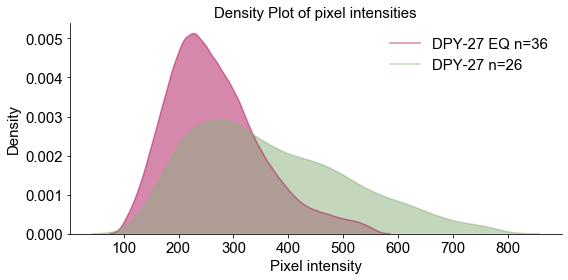

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
rcParams['font.sans-serif'] = ['Arial']

dpy27_cols = [col for col in df_mean_count_pixval.columns if 'EQ' in col 
              or 'sdc-2' in col
              or 'DPY-27' in col 
              if not 'short' in col
              if not 'set' in col
              if not 'halo' in col
              if not 'sir' in col
              if not 'DPY-21' in col
             ]

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for col in df_mean_count_pixval[dpy27_cols]:
    ax = sns.distplot(df_mean_count_pixval[col],
                      hist=False, label= col, 
                      color=color_dict[col],
                      kde_kws = {'alpha':0.5, 'shade': True}
                     )
    
plt.legend(prop={'size': 15}, frameon=False)
plt.xticks(fontsize=15)



plt.yticks(fontsize=15)
plt.title('Density Plot of pixel intensities', fontsize=15)
plt.xlabel('Pixel intensity', fontsize=15)
plt.ylabel('Density', fontsize=15)
#plt.yscale('log')
#plt.xlim(-20,900)
plt.tight_layout()
#plt.savefig('Pixel_intensity_values_for_DPY27_EQ.png', dpi=300)
plt.show()


# Plot curves for EQ + short recovery

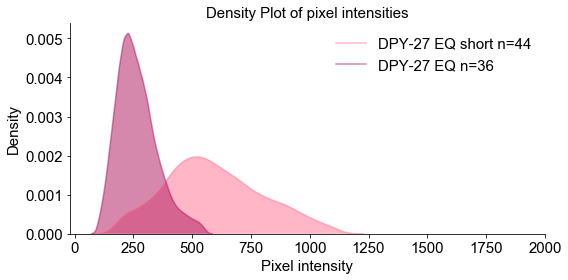

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
rcParams['font.sans-serif'] = ['Arial']

dpy27_cols = [col for col in df_mean_count_pixval.columns if 'EQ' in col 
             # or 'sdc-2' in col
             # or 'DPY-27' in col 
             # if not 'short' in col
              if not 'set' in col
              if not 'halo' in col
              if not 'sir' in col
              if not 'DPY-21' in col
              if not 'sdc-2' in col
             ]


#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for col in df_mean_count_pixval[dpy27_cols]:
    ax = sns.distplot(df_mean_count_pixval[col],
                      hist=False, label= col, 
                      color=color_dict[col],
                      kde_kws = {'alpha':0.5, 'shade': True} )
    
plt.legend(prop={'size': 15}, frameon=False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Density Plot of pixel intensities', fontsize=15)
plt.xlabel('Pixel intensity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(-20,2000)
plt.tight_layout()
#plt.savefig('Pixel_intensity_values_for_EQ_short-rec.png', dpi=300)
#plt.savefig('Pixel_intensity_values_for_EQ_short-rec.svg', dpi=100)
plt.show()

# Plot curves for DPY-27+ short recovery

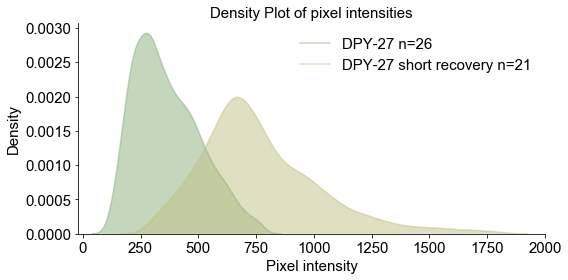

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

rcParams['font.sans-serif'] = ['Arial']
dpy27_cols = [col for col in df_mean_count_pixval.columns if 'DPY-27' in col 
             # or 'sdc-2' in col
             # or 'DPY-27' in col 
              if not 'EQ' in col
              if not 'set' in col
              if not 'halo' in col
              if not 'sir' in col
              if not 'DPY-21' in col
              if not 'sdc-2' in col
             ]

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for col in df_mean_count_pixval[dpy27_cols]:
    ax = sns.distplot(df_mean_count_pixval[col],
                      hist=False, label= col, 
                      color=color_dict[col],
                      kde_kws = {'alpha':0.5, 'shade': True} )
    
  
plt.legend(prop={'size': 15}, frameon=False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Density Plot of pixel intensities', fontsize=15)
plt.xlabel('Pixel intensity', fontsize=15)
plt.ylabel('Density', fontsize=15)
#plt.yscale('log')
plt.xlim(-20,2000)
plt.tight_layout()
#plt.savefig('Pixel_intensity_values_for_DPY-27_short-rec.png', dpi=300)
#plt.savefig('Pixel_intensity_values_for_DPY-27_short-rec.svg', dpi=100)
plt.show()

# Plot curves for DPY-21

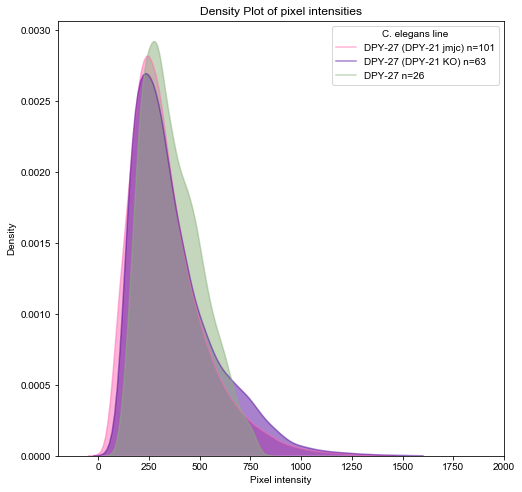

In [29]:
fig = plt.figure(figsize=(8,8))

dpy27_cols = [col for col in df_mean_count_pixval.columns if 'DPY' in col 
             # or 'sdc-2' in col
            #  or 'DPY-27' in col 
             # if not 'short' in col
              if not 'set' in col
              if not 'halo' in col
              if not 'sir' in col
              if not 'EQ' in col
              if not 'sdc-2' in col
              if not 'short' in col
             ]


for col in df_mean_count_pixval[dpy27_cols]:
    ax = sns.distplot(df_mean_count_pixval[col],
                      hist=False, label= col, 
                      color=color_dict[col],
                      kde_kws = {'alpha':0.5, 'shade': True} )
    

plt.legend(prop={'size': 10}, title = 'C. elegans line')
plt.title('Density Plot of pixel intensities')
plt.xlabel('Pixel intensity')
plt.ylabel('Density')
#plt.yscale('log')
plt.xlim(-200,2000)
plt.show()